# kamAI

We will demonstrate a system that recognizes numbers from hand gestures.  
It is similar to the final project in Coursera's `Improving Deep Neural Networks: Hyperparameter tuning, Regularization and Optimization` but will be implemented using `Tensorflow 2`.  
<img src="images/hand-gestures.png">  
  
Let's start with the modules needed.

In [1]:
import tensorflow as tf
import numpy as np
import h5py
import matplotlib.pyplot as plt

## Explore the dataset

We load the dataset from the H5 files.

In [2]:
train_dataset = h5py.File('datasets/train_signs.h5', "r")

train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

test_dataset = h5py.File('datasets/test_signs.h5', "r")
test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

classes = np.array(test_dataset["list_classes"][:]) # the list of classes

train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0])).T
test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0])).T

print ("train_set_x_orig's shape: " + str(train_set_x_orig.shape))
print ("train_set_y_orig's shape: " + str(train_set_y_orig.shape))
print ("test_set_x_orig's shape: " + str(test_set_x_orig.shape))
print ("test_set_y_orig's shape: " + str(test_set_y_orig.shape))

# normalize values between 0 to 1
train_set_x_orig = train_set_x_orig / 255
test_set_x_orig = test_set_x_orig / 255

train_set_x_orig's shape: (1080, 64, 64, 3)
train_set_y_orig's shape: (1080, 1)
test_set_x_orig's shape: (120, 64, 64, 3)
test_set_y_orig's shape: (120, 1)


In the training samples, we have 1080 `64 x 64 x 3` RGB images while the test samples have 120 RGB images.  
  
Here are the images from the training set.

In [ ]:
for index in range(len(train_set_x_orig)):
    plt.imshow(train_set_x_orig[index])
    print("idx(" + str(index) +") y("+str(train_set_y_orig.T[0,index])+") : " + str(classes[train_set_y_orig.T[0,index]]))
    plt.show()

Here are the images from the test set.

In [ ]:
for index in range(len(test_set_x_orig)):
    plt.imshow(test_set_x_orig[index])
    print("idx(" + str(index) +") y("+str(test_set_y_orig.T[0,index])+") : " + str(classes[test_set_y_orig.T[0,index]]))
    plt.show()

## Model Creation

Let's try to create a 3-layer neural network model for this problem.  
Note that the problem now has `multiple classes for classification` which can be extended from the `binary classification` problem.  
  
This command is called first to avoid casting of float64 to float32 (Tensorflow warning).

In [85]:
tf.keras.backend.set_floatx('float64')
model_dir = 'models/initial_model'  # used for saving and loading a trained model

Similar to what we did in the cat classification problem in [cAIt-sith](https://github.com/scrappycoc0/cAIth-sith), we will make a stack of layers using Tensorflow.  
What differs from [cAIt-sith](https://github.com/scrappycoc0/cAIth-sith) is that, the last node will require `softmax` activation function since we have a multiple classification problem.  
  
<font color='red'>Note that we did not put the `softmax` activation on purpose as we plan to use the logits output instead.</font>  
See the more helpful explanation from [Tensorflow](https://www.tensorflow.org/tutorials/quickstart/beginner) instead.

In [86]:
def multiple_class_stacked_model(model_struct, input_shape, num_classification, dropout_rate):
    """
    Creates a sequential neural network model for a multiple classification problem
    
    Arguments:
    model_struct       -- list of hidden layers as tuples containing the number of nodes and the activation function
                          Example: model_struct = [(20, 'relu'), (1, 'sigmoid')]
    input_shape        -- shape of the input used for flattening
    num_classification -- number of objects to be classified (basis for output)
    dropout_rate       -- dropout rate for regularization
    
    Returns:
    model        -- a tensorflow model
    """
    # create model
    model = tf.keras.models.Sequential([
                tf.keras.layers.Flatten(input_shape=input_shape),
                tf.keras.layers.Dropout(dropout_rate)
            ])

    # add hidden layers
    for layer_param in model_struct:
        model.add(tf.keras.layers.Dense(layer_param[0], activation=layer_param[1]))
        model.add(tf.keras.layers.Dropout(dropout_rate))

    # final layer
    model.add(tf.keras.layers.Dense(num_classification))
    
    return model

The dataset label is represented by a single value between 0 to 5 that represents the hand gestures.  
To use Tensorflow, we must do a `one hot encoding` to it.  
<img src="images/onehot.png" width="500" height="250"> 

In [87]:
def one_hot_encoding(input_vector, num_possible_output):
    """
    Convert an mx1 vector to one hot encoding
    
    Arguments:
    input_vector -- an (m x 1) input vector where each value denotes a single class
    num_possible_output -- number of classifications possible
    
    Returns:
    one_hot_vector -- an (m x num_possible_output) one hot encoded vector
    """
    oh = tf.one_hot(input_vector, num_possible_output) # one hot tensor
    one_hot_vector = oh.numpy()
    
    # turns the (m x 1 x num_possible_output) matrix to an (m x num_possible_output) vector
    one_hot_vector = one_hot_vector.reshape(one_hot_vector.shape[0], -1)
    
    return one_hot_vector

Since this is a multiple classification problem, we cannot use the `Binary Cross Entropy` as a loss function.  
Instead, we can use [Categorical Cross Entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy?hl=en) or [Sparse Categorical Cross Entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy?hl=en).  
On the documentation itself, it says that the `Categorical Cross Entropy` expects that the labels are in `one hot encoding`.  
Since we already performed the `one hot encoding` in our labels, we might as well use the `Categorical Cross Entropy`.  
  
Note here that the `tf.nn.softmax()` converts the logits to probabilities in the prediction, so we can:
1. Use the probabilities and the loss function where the parameter `from_logits=False`, or
2. Use the logits and the loss function where the parameter `from_logits=True`  
  
We also use the `Adam` optimization since we are just familiar with `RMSProp` and `Adam` for now.  

In [88]:
def multiple_class_optimize_model(model, training_samples, one_hot_training_labels, learning_rate):
    """
    Compiles a multiple classification neural network model using Adam optimization
    Arguments:
    model            -- a tensorflow model
    training_samples -- numpy array of training samples of size m x ... where m is the number of trainings samples
    one_hot_training_labels   -- numpy array of training labels of size m x n where n is the number of classes
    learning_rate    -- learning rate during gradient descent (hyperparameter)
    beta_1           -- exponential decay rate for 1st moment (hyperparameter)
    beta_2           -- exponential decay rate for 2nd moment (hyperparameter)
    epsilon          -- small number to avoid dividing by 0 during parameter update (hyperparameter)
    
    Returns:
    model            -- a compiled tensorflow model ready for training
    """
    # loss
    loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

    # prediction
    predictions = model(training_samples).numpy()
    print('Initial loss is ' + str(loss_function(one_hot_training_labels, predictions).numpy()))
    
    # optimizer
    optim_adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # compilation
    model.compile(optimizer=optim_adam, loss=loss_function, metrics=['accuracy'])
    
    return model

Now that all functions have been defined, we are now ready to instantiate a model and start training.

In [148]:
num_of_possible_output = 6 # 0 - 5 values using 1-hand gesture

# hyperparameters
model_struct = [(80, 'relu'), 
                (25, 'relu'), 
                (12, 'relu')]
learning_rate = 0.0001
dropout_rate =  0.01

# one hot encoding for training labels
one_hot_training_labels = one_hot_encoding(train_set_y_orig, num_of_possible_output)
print('One hot training shape (after reshape): ' + str(one_hot_training_labels.shape))

# model creation & optimization
model = multiple_class_stacked_model(model_struct, train_set_x_orig[0].shape, num_of_possible_output, dropout_rate)
model = multiple_class_optimize_model(model, train_set_x_orig, one_hot_training_labels, learning_rate)
model.summary()

history = model.fit(train_set_x_orig, one_hot_training_labels, epochs=400)

One hot training shape (after reshape): (1080, 6)
Initial loss is 2.094226121902466
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_27 (Flatten)         (None, 12288)             0         
_________________________________________________________________
dropout_113 (Dropout)        (None, 12288)             0         
_________________________________________________________________
dense_113 (Dense)            (None, 80)                983120    
_________________________________________________________________
dropout_114 (Dropout)        (None, 80)                0         
_________________________________________________________________
dense_114 (Dense)            (None, 25)                2025      
_________________________________________________________________
dropout_115 (Dropout)        (None, 25)                0         
___________________________________

34/34 [==============================] - 2s 56ms/step - loss: 0.9971 - accuracy: 0.6537
Epoch 66/400
34/34 [==============================] - 1s 43ms/step - loss: 1.0210 - accuracy: 0.6472
Epoch 67/400
34/34 [==============================] - 1s 36ms/step - loss: 0.9723 - accuracy: 0.6769
Epoch 68/400
34/34 [==============================] - 1s 36ms/step - loss: 0.9789 - accuracy: 0.6639
Epoch 69/400
34/34 [==============================] - 1s 33ms/step - loss: 0.9538 - accuracy: 0.6676
Epoch 70/400
34/34 [==============================] - 1s 35ms/step - loss: 0.9278 - accuracy: 0.6889
Epoch 71/400
34/34 [==============================] - 1s 32ms/step - loss: 0.9479 - accuracy: 0.6676
Epoch 72/400
34/34 [==============================] - 1s 33ms/step - loss: 0.9521 - accuracy: 0.6713
Epoch 73/400
34/34 [==============================] - 1s 43ms/step - loss: 0.9461 - accuracy: 0.6611
Epoch 74/400
34/34 [==============================] - 1s 40ms/step - loss: 0.9085 - accuracy: 0.6824
Epo

34/34 [==============================] - 1s 40ms/step - loss: 0.5895 - accuracy: 0.8102
Epoch 146/400
34/34 [==============================] - 1s 34ms/step - loss: 0.5785 - accuracy: 0.8046
Epoch 147/400
34/34 [==============================] - 1s 36ms/step - loss: 0.5894 - accuracy: 0.8056
Epoch 148/400
34/34 [==============================] - 1s 40ms/step - loss: 0.5330 - accuracy: 0.8287
Epoch 149/400
34/34 [==============================] - 1s 44ms/step - loss: 0.5385 - accuracy: 0.8213
Epoch 150/400
34/34 [==============================] - 1s 39ms/step - loss: 0.5392 - accuracy: 0.8130
Epoch 151/400
34/34 [==============================] - 1s 39ms/step - loss: 0.5570 - accuracy: 0.8231
Epoch 152/400
34/34 [==============================] - 1s 35ms/step - loss: 0.5469 - accuracy: 0.8250
Epoch 153/400
34/34 [==============================] - 1s 35ms/step - loss: 0.5289 - accuracy: 0.8259
Epoch 154/400
34/34 [==============================] - 1s 33ms/step - loss: 0.5168 - accuracy: 0

34/34 [==============================] - 1s 32ms/step - loss: 0.3130 - accuracy: 0.9130
Epoch 226/400
34/34 [==============================] - 1s 31ms/step - loss: 0.3716 - accuracy: 0.8861
Epoch 227/400
34/34 [==============================] - 1s 33ms/step - loss: 0.3502 - accuracy: 0.8944
Epoch 228/400
34/34 [==============================] - 1s 34ms/step - loss: 0.3668 - accuracy: 0.8824
Epoch 229/400
34/34 [==============================] - 1s 36ms/step - loss: 0.3235 - accuracy: 0.9019
Epoch 230/400
34/34 [==============================] - 1s 33ms/step - loss: 0.3254 - accuracy: 0.9056
Epoch 231/400
34/34 [==============================] - 1s 35ms/step - loss: 0.3232 - accuracy: 0.9037
Epoch 232/400
34/34 [==============================] - 1s 42ms/step - loss: 0.3355 - accuracy: 0.9028
Epoch 233/400
34/34 [==============================] - 1s 42ms/step - loss: 0.3326 - accuracy: 0.9046
Epoch 234/400
34/34 [==============================] - 2s 47ms/step - loss: 0.3387 - accuracy: 0

34/34 [==============================] - 1s 39ms/step - loss: 0.2160 - accuracy: 0.9426
Epoch 304/400
34/34 [==============================] - 1s 43ms/step - loss: 0.2197 - accuracy: 0.9352
Epoch 305/400
34/34 [==============================] - 1s 40ms/step - loss: 0.2128 - accuracy: 0.9389
Epoch 306/400
34/34 [==============================] - 2s 47ms/step - loss: 0.2320 - accuracy: 0.9259
Epoch 307/400
34/34 [==============================] - 2s 59ms/step - loss: 0.2425 - accuracy: 0.9278
Epoch 308/400
34/34 [==============================] - 2s 58ms/step - loss: 0.2219 - accuracy: 0.9324
Epoch 309/400
34/34 [==============================] - 2s 62ms/step - loss: 0.2049 - accuracy: 0.9389
Epoch 310/400
34/34 [==============================] - 2s 55ms/step - loss: 0.2094 - accuracy: 0.9426 1s - loss: 0.2140 - accuracy - ETA: 1s - loss: 0.1995 - accuracy: 0.95 - ETA: 0s - loss: 0.199 - ETA: 0s - loss: 0.2002 - accu
Epoch 311/400
34/34 [==============================] - 2s 48ms/step - l

34/34 [==============================] - 1s 32ms/step - loss: 0.1820 - accuracy: 0.9444
Epoch 382/400
34/34 [==============================] - 1s 37ms/step - loss: 0.1705 - accuracy: 0.9481
Epoch 383/400
34/34 [==============================] - 1s 33ms/step - loss: 0.1126 - accuracy: 0.9694
Epoch 384/400
34/34 [==============================] - 1s 34ms/step - loss: 0.1377 - accuracy: 0.9593
Epoch 385/400
34/34 [==============================] - 1s 30ms/step - loss: 0.1275 - accuracy: 0.9639
Epoch 386/400
34/34 [==============================] - 1s 30ms/step - loss: 0.1401 - accuracy: 0.9556
Epoch 387/400
34/34 [==============================] - 1s 34ms/step - loss: 0.1329 - accuracy: 0.9639
Epoch 388/400
34/34 [==============================] - 1s 33ms/step - loss: 0.1766 - accuracy: 0.9537
Epoch 389/400
34/34 [==============================] - 1s 36ms/step - loss: 0.1662 - accuracy: 0.9528
Epoch 390/400
34/34 [==============================] - 1s 37ms/step - loss: 0.1512 - accuracy: 0

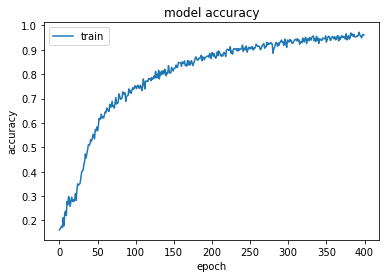

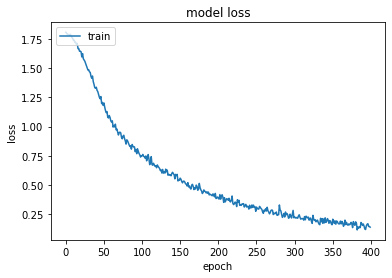

In [149]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

Let's save the model which can be loaded next time to avoid re-training again.

In [155]:
tf.keras.models.save_model(model, model_dir)

INFO:tensorflow:Assets written to: models/initial_model\assets


INFO:tensorflow:Assets written to: models/initial_model\assets


## Model Evaluation

The current model we have has a training set accuracy of <b>96.02%</b>.  
Before we check the test set accuracy, we convert the test set labels to `one hot encoding` as well.

In [150]:
# one-hot encoding for test labels
one_hot_test_labels = one_hot_encoding(test_set_y_orig, num_of_possible_output)
print('One hot test shape (after reshape): ' + str(one_hot_test_labels.shape))

One hot test shape (after reshape): (120, 6)


Now, we can evaluate the model's test set performance.

In [151]:
model.evaluate(test_set_x_orig, one_hot_test_labels, verbose=1)

4/4 [==============================] - 0s 6ms/step - loss: 0.3901 - accuracy: 0.8667


[0.3901462286710739, 0.8666666666666667]

This <b>86.67%</b> test set accuracy is an excellent performance for such a simple model.

## Error Analysis

We can check some of the model's error which we could have some generalization to further improve its test set performance.  
Note that this could be a little different from the binary classification problem.  
  
The predictions can be converted from `logits` to probabilities via `tf.nn.softmax()`.  
Then we convert the probability vectors to `one hot encoding` by finding which of the classifications has the largest probability.  
  
If the one hot encoded prediction is not equal to its label, then we found a mislabeled data.  
<font color='red'>The `for-if` section can be further be improved if implemented in vectorized form.</font>

test_set_prediction shape:(120, 6)
max_prediction shape:(120,)
idx:6 oh label:3 oh prediction:5


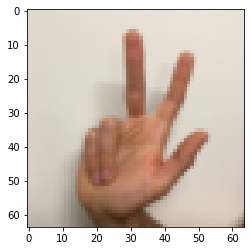

idx:17 oh label:4 oh prediction:5


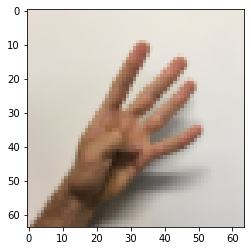

idx:29 oh label:2 oh prediction:5


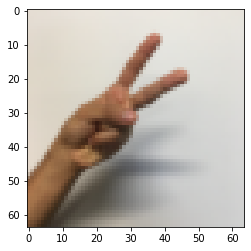

idx:33 oh label:3 oh prediction:5


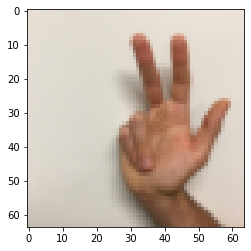

idx:37 oh label:4 oh prediction:3


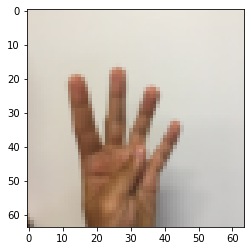

idx:46 oh label:2 oh prediction:1


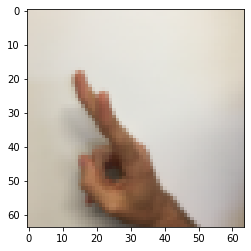

idx:47 oh label:2 oh prediction:5


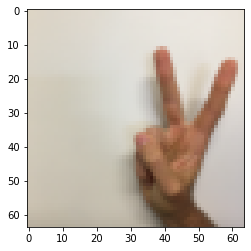

idx:54 oh label:4 oh prediction:2


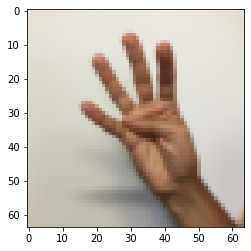

idx:59 oh label:4 oh prediction:5


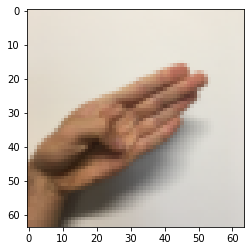

idx:64 oh label:4 oh prediction:3


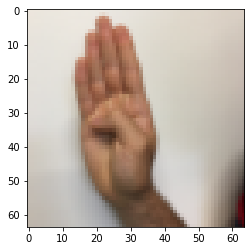

idx:69 oh label:5 oh prediction:3


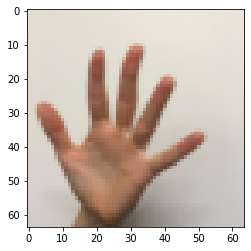

idx:71 oh label:4 oh prediction:5


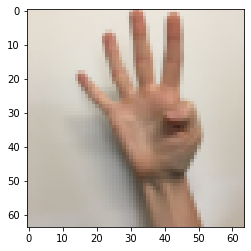

idx:72 oh label:1 oh prediction:5


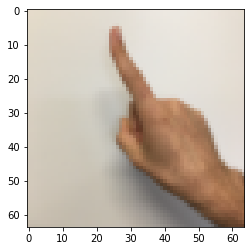

idx:83 oh label:4 oh prediction:3


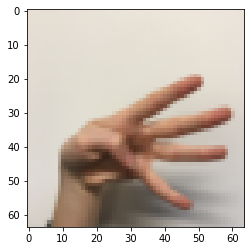

idx:97 oh label:3 oh prediction:5


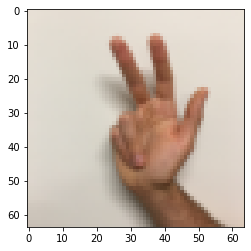

idx:103 oh label:2 oh prediction:5


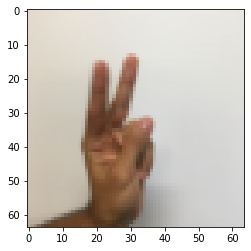

In [152]:
test_set_prediction = model.predict(test_set_x_orig)      # in logits form
test_set_prediction = tf.nn.softmax(test_set_prediction)  # in probabilities
print('test_set_prediction shape:' + str(test_set_prediction.shape))

# finding the max
max_prediction = test_set_prediction.numpy().max(axis=1)
print('max_prediction shape:' + str(max_prediction.shape))

for idx in range(len(test_set_prediction.numpy())):
    # convert the prediction to one hot encoding
    one_hot_prediction = (test_set_prediction.numpy()[idx] == max_prediction[idx]).astype(float)

    if not np.array_equal(one_hot_prediction, one_hot_test_labels[idx]):
        # uncomment for debugging
        # print('idx:'+ str(idx) + ' max pred:' + str(max_prediction[idx]))
        # print('idx:'+ str(idx) + ' test_pre:' + str(test_set_prediction.numpy()[idx]))
        
        print('idx:'+ str(idx) + ' oh label:' + str(one_hot_test_labels[idx].argmax(axis=0)) + ' oh prediction:' + str(one_hot_prediction.argmax(axis=0)))
        
        # show image
        plt.imshow(test_set_x_orig[idx])
        plt.show()

## Making Predictions

We load the saved model.

In [46]:
model = tf.keras.models.load_model(model_dir)

Let's now load our own images to test the model.

In [153]:
from PIL import Image

files = ['five_white_bg.jpg', 'one_white_bg.jpg', 'two_blue_bg.jpg']
files = ['images/' + x for x in files] # append dir

own_dataset = np.zeros((len(files), 64, 64, 3))

# open image
for idx in range(len(files)):
    img = Image.open(files[idx], mode='r')
    # resize if needed, but here I resized all image manually
    own_dataset[idx] = np.array(img)
    img.close()

# normalize dataset
own_dataset = own_dataset/255

We can now let the model recognize the dataset.  
The `logits` from the prediction is converted to probabilities using `softmax`.  
The column with the highest probability is the recognized number of the model.

This image is recognized as 5


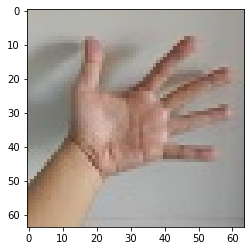

This image is recognized as 1


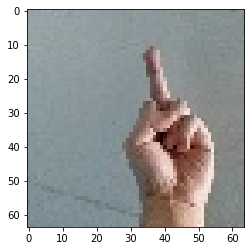

This image is recognized as 2


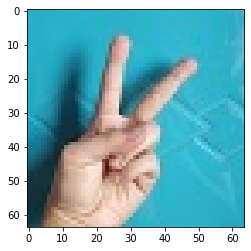

In [154]:
predictions = model.predict(own_dataset)
predicted_probabilities = tf.nn.softmax(predictions)

for idx in range(len(predictions)):
    print('This image is recognized as ' + str(predicted_probabilities[idx].numpy().argmax(axis=0)))
    plt.imshow(own_dataset[idx])
    plt.show()

The training dataset used various hand gestures against a white background.  
It is surprising that the model was effective on the 3rd test image since it has a blue background.